In [1]:
import numpy as np
import pandas as pd

In [2]:
def get_DR_file(year):
    name = 'DSM' if year < 2013 else 'Demand_Response'
    if year == 2012:
        name = 'dsm'
    app = 'xlsx' if (year not in [2012, 2013, 2014]) else 'xls'
    sheet = 'Demand Response_States' if year > 2012 else 'States'
    if year == 2007:
        sheet = 'DSM- States'
    if year == 2008:
        sheet = 'DSM-State'
    if year == 2009:
        sheet = 'DSM'
    head = 2
    df = pd.read_excel(f'data/all_DR/{name}_{year}.{app}', sheet_name=sheet, header=head)
    return df

def get_util_BA_mapping_file(year):
    app = 'xlsx' if (year not in [2013, 2014]) else 'xls'
    sheet = 'States'
    head = 2
    df = pd.read_excel(f'data/all_DR/Sales_Ult_Cust_{year}.{app}', sheet_name=sheet, header=2)
    return df

def util_to_BA_mapping(BAs):
    print(BAs)
    yrs = []
    bas = []
    utils = []
    util_nums = []
    states = []
    for yr in range(2013, 2020):
         
        if yr <= 2016:
            ba_code = 'BA_CODE'
        elif yr == 2016:
            ba_code = 'BA CODE'
        else:
            ba_code = 'BA Code'
        df = get_util_BA_mapping_file(yr)
        #print("\n\n\n\n",yr, ba_code)
        #print(df.head())
        for idx in df.index:
            if df.loc[idx, ba_code] in BAs:
                if df.loc[idx, 'Utility Name'] == 'Adjustment 2019' or df.loc[idx, 'Utility Name'] == 'Withheld':
                    continue
                yrs.append(yr)
                bas.append(df.loc[idx, ba_code])
                utils.append(df.loc[idx, 'Utility Name'])
                util_nums.append(df.loc[idx, 'Utility Number'])
                states.append(df.loc[idx, 'State'])
        
    
    master = pd.DataFrame({'year':yrs, 'BA':bas, 'Utility':utils, 'Utility Number': util_nums, 'State':states})
    master.to_csv('mapping.csv')
    print(master)
    return master

In [3]:
BAs = ['ERCO','NYIS', 'PJM']
M = util_to_BA_mapping(BAs)

['ERCO', 'NYIS', 'PJM']
      year    BA                         Utility  Utility Number State
0     2013   PJM             A & N Electric Coop            84.0    MD
1     2013   PJM             A & N Electric Coop            84.0    VA
2     2013  NYIS      Agway Energy Services, LLC           113.0    NY
3     2013   PJM  Adams Rural Electric Coop, Inc           118.0    OH
4     2013  NYIS        Village of Arcade - (NY)           122.0    NY
...    ...   ...                             ...             ...   ...
7002  2019  NYIS    National Gas & Electric, LLC         63232.0    NJ
7003  2019   PJM    National Gas & Electric, LLC         63232.0    OH
7004  2019   PJM    National Gas & Electric, LLC         63232.0    PA
7005  2019  NYIS       Mirabito Power & Gas, LLC         63364.0    NY
7006  2019   PJM      Provision Power & Gas, LLC         63546.0    OH

[7007 rows x 5 columns]


In [7]:
def assemble_DR(BAs, M, years):

    yrs = []
    bas = []
    pk_avails = []
    pk_actuals = []

    for ba in BAs:
        print(ba)
        #for yr in range(2001, 2020):
        m = M.loc[ M['BA'] == ba]
        for yr in years:
            print(yr)
            dr = get_DR_file(yr)
            #print(dr.head())
            
            # Mapping does not exist prior to 2013,
            # Use 2013 mapping for earlier data
            yr_to_use = yr if yr >= 2013 else 2013
            m2 = m.loc[ m['year'] == yr_to_use]
            pk_avail = 0.
            pk_actual = 0.
            for idx in m2.index:
                # Match based on utility number and state (name will have typos I bet)
                u_num = m2.loc[idx, 'Utility Number']
                u_state = m2.loc[idx, 'State']
                for idx2 in dr.index:
                    if not dr.loc[idx2, 'Utility Number'] == u_num:
                        continue
                    if not dr.loc[idx2, 'State'] == u_state:
                        continue
                    avail = dr.loc[idx2, 'Total.2']
                    actual = dr.loc[idx2, 'Total.3']
                    
                    if type(avail) == type('x') or type(actual) == type('x'):
                        print(u_num, u_state, dr.loc[idx2, 'Utility Name'])
                        print(f"DR idx: {idx2}")
                        print(f"avail {avail}, actual {actual}")
                        print("SKIPPED")
                        continue
                    
                    pk_avail += avail
                    pk_actual += actual
            yrs.append(yr)
            bas.append(ba)
            pk_avails.append(pk_avail)
            pk_actuals.append(pk_actual)
    out = pd.DataFrame({'year': yrs, 'BA':bas, 'Peak Available (MW)':pk_avails, 'Peak Actual (MW)':pk_actuals})
    out.to_csv('DR_output.csv')
    return out
             
# State mapping is only available in years 2010 DSM files onward
years = range(2013, 2020)

DR = assemble_DR(BAs, M, years)    

ERCO
2013
7634.0 TX City of Greenville - (TX)
DR idx: 126
avail ., actual .
SKIPPED
9590.0 TX Jackson Electric Coop, Inc - (TX)
DR idx: 151
avail ., actual 8
SKIPPED
17561.0 TX South Plains Electric Coop Inc
DR idx: 315
avail ., actual .
SKIPPED
2014
4610.0 TX City of Cuero - (TX)
DR idx: 105
avail ., actual .
SKIPPED
7634.0 TX City of Greenville - (TX)
DR idx: 161
avail ., actual .
SKIPPED
17561.0 TX South Plains Electric Coop Inc
DR idx: 408
avail ., actual .
SKIPPED
2015
7634.0 TX City of Greenville - (TX)
DR idx: 130
avail  , actual  
SKIPPED
2016
7634.0 TX City of Greenville - (TX)
DR idx: 129
avail ., actual .
SKIPPED
19327.0 TX TXU Energy Retail Co LP
DR idx: 364
avail ., actual .
SKIPPED
2017
6182.0 TX Farmers Electric Coop, Inc - (TX)
DR idx: 110
avail ., actual .
SKIPPED
7634.0 TX City of Greenville - (TX)
DR idx: 130
avail ., actual .
SKIPPED
2018
17561.0 TX South Plains Electric Coop Inc
DR idx: 323
avail 46, actual .
SKIPPED
2019
NYIS
2013
2014
13573.0 NY Niagara Mohawk Po

In [5]:
import matplotlib.pyplot as plt

   year    BA  Peak Available (MW)  Peak Actual (MW)
0  2013  ERCO                239.5             151.6
1  2014  ERCO                402.5             312.3
2  2015  ERCO                491.4             347.7
3  2016  ERCO                567.6             397.0
4  2017  ERCO                613.0             410.7


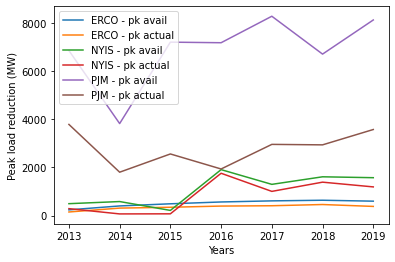

In [10]:
print(DR.head())
fig, ax = plt.subplots()
for ba in BAs:
    dr = DR.loc[ DR['BA'] == ba]
    ax.plot(dr['year'], dr['Peak Available (MW)'], label=f"{ba} - pk avail")
    ax.plot(dr['year'], dr['Peak Actual (MW)'], label=f"{ba} - pk actual")
plt.legend()
ax.set_xlabel('Years')
ax.set_ylabel('Peak load reduction (MW)')
plt.show()